In [25]:
from phi.torch.flow import *
import matplotlib.pyplot as plt

from src.eigenfluid import Eigenfluid
from src.shapes import *

# Helper functions for visualization
from src.visu import *

import time

In [26]:
# Number of basis fields
N = 4**2 
# Domain sizes
DOMAIN = Box(x=math.PI, y=math.PI)
SAMPLING_SIZE = 32

start_time = time.time()
eigenfluid = Eigenfluid(N, DOMAIN, SAMPLING_SIZE)
end_time = time.time()
print("Eigenfluid initialized in {} seconds".format(end_time-start_time))

Eigenfluid initialized in 9.638376951217651 seconds


# Data

<Figure size 300x300 with 1 Axes>

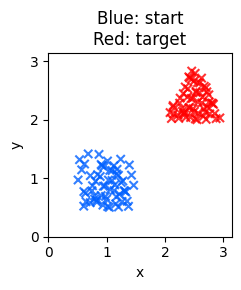

In [32]:
shape_0 = Square(pos=(0.5, 0.5))
shape_target = Triangle(pos=(2, 2))

# Get O overlapping, and U non-necessarily overlapping ('unique') sample points
O = 30
U = 30
sampler_union = ShapeSampler(shape_0, shape_target, N=O, h1=2, h2=7)
sampler_0 = ShapeSampler(shape_0, N=U, h1=3, h2=11)
sampler_target = ShapeSampler(shape_target, N=U, h1=3, h2=11)

# Concatenate both the union and non-union points
p_0 = math.concat((sampler_union.p, sampler_0.p), instance('i'))
p_0 = shape_0.create_points(p_0)
p_target = math.concat((sampler_union.p, sampler_target.p), instance('i'))
p_target = shape_target.create_points(p_target)

plot({"Blue: start\nRed: target": 
     vis.overlay(
        PointCloud(p_0, bounds=DOMAIN),
        PointCloud(p_target, bounds=DOMAIN, color="red")
     )}, 
     size=(3,3))

# Network

In [51]:
# Input: [p_current, p_target, time_to_target, current_w]
# -> Input dimension = [O+U, O+U, N, 1] = O+U + O+U + 1 + N = 137
# Output = [N] force coefficients for current time step
net = dense_net(2*(O+U)+N+1, N, [256, 128, 64, 32], batch_norm=True)
optimizer = adam(net)

print(net)
print("Number of parameters: {}".format(parameter_count(net)))
print()
print("Optimizer:{}".format(optimizer))

DenseNet(
  (linear0): Linear(in_features=137, out_features=256, bias=True)
  (norm0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=256, out_features=128, bias=True)
  (norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=64, out_features=32, bias=True)
  (norm3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear4): Linear(in_features=32, out_features=16, bias=True)
  (norm4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Number of parameters: 80080

Optimizer:Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-07
    foreach: None
    lr: 0.001
    maximize: False
    weight

# Loss Function

In [57]:
LOOK_AHEAD = 4

STEPS = 32
DT    = 0.2
VISCOSITY = 0.0

@math.jit_compile
def loss_function(p_current, p_target, time_to_target, w):
    eigenfluid.w = w
    f_pred = math.native_call(net, p_current, p_target, time_to_target, w)
    print(f_pred)
    # Simulate eigenfluid for up to LOOK_AHEAD time in the future
    if time_to_target > LOOK_AHEAD:
    return math.l2_loss(p_current - p_target), trajectory_p

#loss_function(math.random_normal(batch(examples=100)))
loss_function(p_0, p_target, )

/Users/bobarna/codes/phiflow/phi/math/_functional.py:181: RuntimeWarning: jit_copmile() not supported by NumPy. Running function 'loss_function' as-is.
  warnings.warn(f"jit_copmile() not supported by {key.backend}. Running function '{self.f.__name__}' as-is.", RuntimeWarning)


TypeError: loss_function() missing 4 required positional arguments: 'p_current', 'p_target', 'time_to_target', and 'w'

In [22]:
for i in range(100):
    loss, _, _ = update_weights(net, optimizer, loss_function, math.random_normal(batch(examples=100)))
    if i % 20 == 0: print(loss)

(examplesᵇ=100) 3.23e-05 ± 2.0e-04 (4e-09...2e-03)
(examplesᵇ=100) 8.75e-05 ± 4.7e-04 (2e-09...4e-03)
(examplesᵇ=100) 3.42e-05 ± 8.9e-05 (5e-10...7e-04)
(examplesᵇ=100) 5.87e-04 ± 5.7e-03 (1e-09...6e-02)
(examplesᵇ=100) 2.64e-05 ± 8.0e-05 (1e-11...7e-04)
